<a href="https://colab.research.google.com/github/Falconwatch/cybersec_ht/blob/main/Statistical_method.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
from tqdm import tqdm

In [2]:
!pip install -q Levenshtein

In [3]:
cust_1 = pd.read_excel("cust_1.xlsx")
cust_2 = pd.read_excel("cust_2.xlsx")
examples = pd.read_excel("examples.xlsx")

In [4]:
cust_1 = cust_1.rename({"c1.country_code":"country_code"}, axis=1)
cust_2 = cust_2.rename({"c2.country_code":"country_code"}, axis=1)

In [5]:
countries = cust_1["country_code"].unique()

# Соберу все возможные комбинации

In [6]:
country_datas = list()
for country in countries:
  c1 = cust_1[cust_1["country_code"] == country]
  c2 = cust_2[cust_2["country_code"] == country]
  total = c1.reset_index(drop=True).merge(c2.reset_index(drop=True),
                                          on =["country_code"])
  country_datas.append(total)

In [7]:
all_data = pd.concat(country_datas)
all_data.shape

(5073577, 13)

In [8]:
examples = examples.rename({"c1.country_code":"country_code"}, axis=1).drop("c2.country_code", axis=1)
examples["dataset"] = "examples"

In [9]:
data = all_data.sample(100000).reset_index(drop=True)
data["dataset"] = "data"

In [10]:
full_data = pd.concat([examples, data]).reset_index(drop=True)

In [11]:
full_data.head(4)

,c1.key,c1.hotel_name,c1.city_name,country_code,c1.hotel_address,c1.star_rating,c1.postal_code,c2.key,c2.hotel_name,c2.city_name,c2.hotel_address,c2.star_rating,c2.postal_code,dataset
0,ACA467BD93827F6001DDD139E7AB4299,Atlantis Condo Resort Pattaya By ACC,Pattaya,TH,495/32 2floor Nongprue Banglamung,2.0,20150,845F505251CF1D83547D4669A44D17A4,Atlantis Condo Resort Pattaya by Kulisara,Jomtien Beach,"495/19, Moo 12, Jomtien Sai 2, Tambol Nongprue...",0.0,20250,examples
1,5BB207CBB33F3D099BCD979F86B3F54B,Chongqing Yangtze River Internatioanl Youth Ho...,Chongqing,CN,"No. 80, Changbin Road, Chao Tian Men Port",3.0,400010,9288C09CFB7714C3CAF57723C04BB6A4,Yangtze River International Youth Hostel,Chongqing,"No 80,Changbin Rd,Dock 11,ChaoTianMen,Yuzhong ...",2.0,400010,examples
2,97318B24C9C927AB8F50B13B44A706B5,Guangdong Hotel Zhuhai,Zhuhai,CN,"No. 1145 Yuehai Dong Road, Gongbei",4.0,519020,881982B8562A58BF3822C727B8A0C361,Guang Dong Hotel Zhuhai,Zhuhai,"No.1145, Yuehai East Road",4.0,519020,examples
3,03D43FDF92B0155912C46D8CEA46A874,Hampton Inn Nanuet - NY Hotel,Nanuet (NY),US,260 West Route 59,2.5,10954,F2A0C113B4F04002A6549BD940C54A95,Hampton Inn Nanuet,Nanuet,260 West Route 59,3.0,10954,examples


# Вычислю фичи сходства
Идеи:
- Улучшить вычисление расстояния для почтового кода - сверять слева направо

In [12]:
from Levenshtein import distance as levenshtein_distance

In [13]:
from difflib import SequenceMatcher
def similarity_ratio_func(df, field):
  
  def string_similarity(s1,s2):
    s1 = [c for c in s1 if c not in [",", ";", ".", ""]]
    #return levenshtein_distance(s1,s2)
    return SequenceMatcher(isjunk = lambda x: x in " ,;./-_", a = str(s1).upper(), b=str(s2).upper()).ratio()

  def postalcode_similarity(s1, s2):
    longest_string = max([len(s1), len(s2)])
    s1 = s1+"0"*(longest_string - len(s1))
    s2 = s2+"0"*(longest_string - len(s2))

    t = [a==b for a,b in zip(s1, s2)][::-1]

    max_possible_similarity = sum([10**i for i in range(longest_string)])
    current_similarity = sum([t[i]*10**i for i in range(len(t))])
    difference = max_possible_similarity - current_similarity
    difference_ratio = difference/max_possible_similarity
    return difference_ratio
  
  def rating_star_diff(s1, s2):
    #r = abs(float(s1), float(s2))
    try:
      r = abs(float(s1)- float(s2))
      return r
    except:
      return None

  def universal_wrapper(x1, x2, func):
    if pd.isna(x1) or pd.isna(x2):
      return None
    x1=str(x1).upper()
    x2=str(x2).upper()
    return func(x1,x2)

  name1 = "c1." + field
  name2 = "c2." + field
  name3 = field + "_similarity"
  
  if "postal_code" in field:
    df[name3] = df[[name1, name2]].apply(lambda x: universal_wrapper(x[name1], x[name2], postalcode_similarity),
                                          axis=1)
  elif "star_rating" in field:
    df[name3] = df[[name1, name2]].apply(lambda x: universal_wrapper(x[name1], x[name2], rating_star_diff),
                                          axis=1)

  else:
    df[name3] = df[[name1, name2]].apply(lambda x: universal_wrapper(x[name1], x[name2], string_similarity),
                                          axis=1)

In [14]:
feature_fields = [c[3:] for c in cust_1.columns[1:] if "country" not in c]

In [15]:
for ff in tqdm(feature_fields):
  similarity_ratio_func(full_data, ff)

100%|██████████| 5/5 [00:52<00:00, 10.56s/it]


In [16]:
features = [c for c in full_data.columns if ("_similarity" in c) and ("_normed" not in c)]
ids = ["c1.key", "c2.key"]
features+ids

['hotel_name_similarity',
 'city_name_similarity',
 'hotel_address_similarity',
 'star_rating_similarity',
 'postal_code_similarity',
 'c1.key',
 'c2.key']

# Статистический подход

In [17]:
#Для дальнейшей нормализации
means = full_data.loc[full_data["dataset"]=="examples", features].mean()
stds = full_data.loc[full_data["dataset"]=="examples", features].std()

In [18]:
stds

hotel_name_similarity       0.070656
city_name_similarity        0.110524
hotel_address_similarity    0.092940
star_rating_similarity      0.934532
postal_code_similarity      0.098345
dtype: float64

In [19]:
means

hotel_name_similarity       0.249482
city_name_similarity        0.233571
hotel_address_similarity    0.198316
star_rating_similarity      0.561605
postal_code_similarity      0.011729
dtype: float64

In [20]:
#нормализуем
for f in features:
  full_data[f+"_normed"] = (full_data[f]-means[f])/stds[f]

In [21]:
features

['hotel_name_similarity',
 'city_name_similarity',
 'hotel_address_similarity',
 'star_rating_similarity',
 'postal_code_similarity']

dataset
data        AxesSubplot(0.125,0.125;0.775x0.755)
examples    AxesSubplot(0.125,0.125;0.775x0.755)
Name: hotel_name_similarity_normed, dtype: object

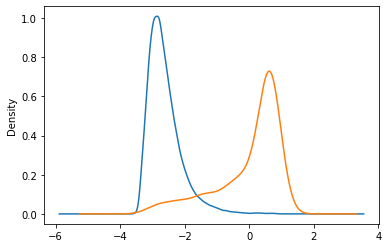

In [22]:
full_data.groupby('dataset')['hotel_name_similarity_normed'].plot(kind='kde')

dataset
data        AxesSubplot(0.125,0.125;0.775x0.755)
examples    AxesSubplot(0.125,0.125;0.775x0.755)
Name: city_name_similarity_normed, dtype: object

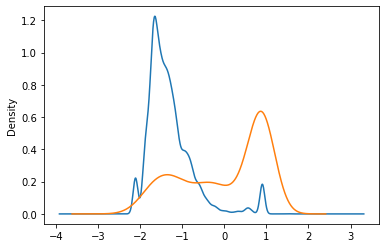

In [23]:
full_data.groupby('dataset')['city_name_similarity_normed'].plot(kind='kde')

dataset
data        AxesSubplot(0.125,0.125;0.775x0.755)
examples    AxesSubplot(0.125,0.125;0.775x0.755)
Name: hotel_address_similarity_normed, dtype: object

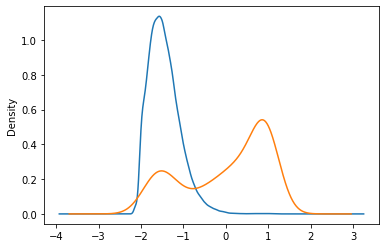

In [24]:
full_data.groupby('dataset')['hotel_address_similarity_normed'].plot(kind='kde')

dataset
data        AxesSubplot(0.125,0.125;0.775x0.755)
examples    AxesSubplot(0.125,0.125;0.775x0.755)
Name: star_rating_similarity_normed, dtype: object

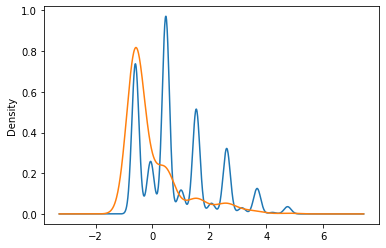

In [25]:
full_data.groupby('dataset')['star_rating_similarity_normed'].plot(kind='kde')

dataset
data        AxesSubplot(0.125,0.125;0.775x0.755)
examples    AxesSubplot(0.125,0.125;0.775x0.755)
Name: postal_code_similarity_normed, dtype: object

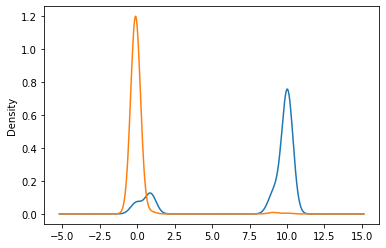

In [26]:
full_data.groupby('dataset')['postal_code_similarity_normed'].plot(kind='kde')

#Квантили распределений

In [27]:
from scipy import stats

In [28]:
full_data.columns

Index(['c1.key', 'c1.hotel_name', 'c1.city_name', 'country_code',
       'c1.hotel_address', 'c1.star_rating', 'c1.postal_code', 'c2.key',
       'c2.hotel_name', 'c2.city_name', 'c2.hotel_address', 'c2.star_rating',
       'c2.postal_code', 'dataset', 'hotel_name_similarity',
       'city_name_similarity', 'hotel_address_similarity',
       'star_rating_similarity', 'postal_code_similarity',
       'hotel_name_similarity_normed', 'city_name_similarity_normed',
       'hotel_address_similarity_normed', 'star_rating_similarity_normed',
       'postal_code_similarity_normed'],
      dtype='object')

In [29]:
examples_tmp = full_data.loc[full_data["dataset"]=='examples']
for f in tqdm(features):
  full_data[f+"_normed_percentilte"] =\
    full_data[f+"_normed"].apply(lambda x: stats.percentileofscore(examples_tmp[f+"_normed"], x)/100)

100%|██████████| 5/5 [00:04<00:00,  1.00it/s]


In [30]:
#full_data.sample(10000).to_excel("full_data_sample.xlsx")

## Проверим гипотезы
Множественная проверка from statsmodels.stats.multitest import multipletests показала тебя плохо

In [31]:
percentiles_fields = [c for c in full_data.columns if "_normed_percentilte" in c]
percentiles_fields

['hotel_name_similarity_normed_percentilte',
 'city_name_similarity_normed_percentilte',
 'hotel_address_similarity_normed_percentilte',
 'star_rating_similarity_normed_percentilte',
 'postal_code_similarity_normed_percentilte']

In [62]:
#выберу такой порог отсечнеия чтобы максимально отвести примеры от всех данных
data_rejected = list()
ex_rejected = list()
for pcrit in tqdm(range(0,100,1)):
  rejection = list()
  for f in percentiles_fields:
    name = f[:-30]+"_reject"
    rejection.append(name)
    full_data[name] = full_data[f].apply(lambda x: int(x<pcrit/100))

  full_data["total_rejects"] = full_data[rejection].sum(axis=1)
  
  stats = full_data.groupby("dataset")["total_rejects"].mean()
  data_rejected.append(stats["data"])
  ex_rejected.append(stats["examples"])

  #print(pcrit/100)

100%|██████████| 100/100 [00:17<00:00,  5.64it/s]


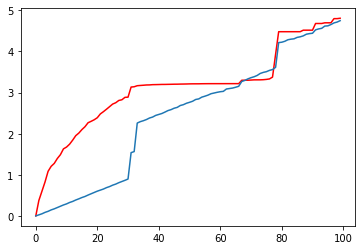

In [64]:
import matplotlib.pyplot as plt
plt.plot(data_rejected, color="red")
plt.plot(ex_rejected)

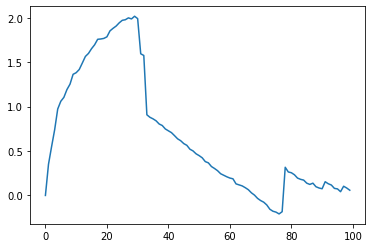

In [66]:
plt.plot([d-e for d,e in zip(data_rejected,ex_rejected)])

In [67]:
rejection = list()
for f in percentiles_fields:
  name = f[:-30]+"_reject"
  rejection.append(name)
  full_data[name] = full_data[f].apply(lambda x: int(x<0.3))

full_data["total_rejects"] = full_data[rejection].sum(axis=1)

In [68]:
#full_data[rejection+["total_rejects"]]

In [69]:
#full_data.to_excel("full_data.xlsx")

## Разметим несовпадения
Для этого отберём такие наблюдения, где нулевая гипотеза (о равенстве признаков) уверенно отвергается

In [70]:
full_data

,c1.key,c1.hotel_name,c1.city_name,country_code,c1.hotel_address,c1.star_rating,c1.postal_code,c2.key,c2.hotel_name,c2.city_name,...,city_name_similarity_normed_percentilte,hotel_address_similarity_normed_percentilte,star_rating_similarity_normed_percentilte,postal_code_similarity_normed_percentilte,hotel_name_reject,city_name_reject,hotel_address_reject,star_rating_reject,postal_code_reject,total_rejects
0,ACA467BD93827F6001DDD139E7AB4299,Atlantis Condo Resort Pattaya By ACC,Pattaya,TH,495/32 2floor Nongprue Banglamung,2.0,20150,845F505251CF1D83547D4669A44D17A4,Atlantis Condo Resort Pattaya by Kulisara,Jomtien Beach,...,0.041547,0.237822,0.901146,0.744986,0,1,1,0,0,2
1,5BB207CBB33F3D099BCD979F86B3F54B,Chongqing Yangtze River Internatioanl Youth Ho...,Chongqing,CN,"No. 80, Changbin Road, Chao Tian Men Port",3.0,400010,9288C09CFB7714C3CAF57723C04BB6A4,Yangtze River International Youth Hostel,Chongqing,...,0.782235,0.297994,0.782235,0.329513,1,0,1,0,0,2
2,97318B24C9C927AB8F50B13B44A706B5,Guangdong Hotel Zhuhai,Zhuhai,CN,"No. 1145 Yuehai Dong Road, Gongbei",4.0,519020,881982B8562A58BF3822C727B8A0C361,Guang Dong Hotel Zhuhai,Zhuhai,...,0.782235,0.283668,0.308023,0.329513,0,0,1,0,0,1
3,03D43FDF92B0155912C46D8CEA46A874,Hampton Inn Nanuet - NY Hotel,Nanuet (NY),US,260 West Route 59,2.5,10954,F2A0C113B4F04002A6549BD940C54A95,Hampton Inn Nanuet,Nanuet,...,0.365330,0.687679,0.660458,0.329513,1,0,0,0,0,1
4,3E450E4AF4A57D230A480691C7B26A04,Dong Fang Hotel,Beijing,CN,"No.11 Wan Ming Road, Xicheng District",4.0,NaN,D450980246198F0BCBFB260F2B6E81F5,Dong Fang Hotel Beijing,Beijing,...,0.782235,0.312321,0.308023,NaN,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100344,DAF8372357577B660385E0FA7ED4FC9F,Hi Inn Suzhou Guanqian Branch,Suzhou,CN,"No. 22 Yin Guo Lane, Gusu District",2.0,215000,53A20FCC6E576F73991DA7412B780154,Hanting Express Qingdao Licang Square,Qingdao,...,0.088825,0.237822,0.308023,0.772206,1,1,1,0,0,3
100345,414C3427A972CFA1E484921031DCE9B9,Best Western PLUS All Settlers Motor Inn,Tamworth,AU,191 Goonoo Goonoo Road,4.5,2340,CF18D2B11EA5F49154D84B73A9242E93,Kakadu @ the Kube,Darwin,...,0.157593,0.031519,0.660458,0.779370,1,1,1,0,0,3
100346,4146BCB7CB227A7B2ACCEEF54DE227D5,Friendly Angkor Boutique Hotel,Siem Reap,KH,"#150 meters North of Angkor Night Market, Steu...",3.5,172525,DCD6A5DA9065EB65355406FD4A444A56,New Hill Resort & Spa,Sihanoukville,...,0.212034,0.011461,0.660458,NaN,1,1,1,0,0,3
100347,13E43B44DCBC0D61AFD539EFCA5DBC78,Hotel Star Inn,Ganganagar,IN,"Plot No.14, Ravinder Path, Opposite Chanderlook",4.0,335001,EEDA38B3B1A1D1E653B59B6E5A3A5BA2,Sterling Holidays Karwar - Emerald Bay,Kārwār,...,0.028653,0.054441,0.782235,0.779370,1,1,1,0,0,3


In [71]:
full_data.groupby("dataset")["total_rejects"].mean()

dataset
data        2.887800
examples    0.896848
Name: total_rejects, dtype: float64

In [79]:
bad_examples = full_data[full_data["total_rejects"]>2]
good_examples = full_data[full_data["total_rejects"]<1]

In [80]:
good_examples.loc[good_examples["dataset"]=="data"]

,c1.key,c1.hotel_name,c1.city_name,country_code,c1.hotel_address,c1.star_rating,c1.postal_code,c2.key,c2.hotel_name,c2.city_name,...,city_name_similarity_normed_percentilte,hotel_address_similarity_normed_percentilte,star_rating_similarity_normed_percentilte,postal_code_similarity_normed_percentilte,hotel_name_reject,city_name_reject,hotel_address_reject,star_rating_reject,postal_code_reject,total_rejects
855,665A0D0B2229D18399E05EB2DA3F9E25,Maartens Guesthouse,Cape Town,ZA,39 Avenue Normandie,3.0,8005,C8EE2CCE3E6BC0A3DB40DD08EBCB1B58,Maartens Guesthouse,Cape Town,...,0.508596,0.957020,0.308023,0.329513,0,0,0,0,0,0
1397,42A27DDE83690689A9A02C6F0A754B02,Best Western Lake Cumberland Inn,Monticello (KY),US,2030 E Highway 90,3.0,42633-5949,BD71CC43DED57E670BD183F12CB04C85,Best Western Lake Cumberland Inn,Monticello,...,0.444126,0.630372,0.782235,0.684814,0,0,0,0,0,0
3785,EC955734DAD65AD085D17FBECDDC6781,Palo Santo Hotel,Buenos Aires,AR,Bonpland 2275,4.0,C1425FWC,12304EED813C5640CA2765318EDD9480,Palo Santo Hotel,Buenos Aires,...,0.545845,0.991404,0.308023,0.329513,0,0,0,0,0,0
5176,FBD286A7D868AF3260B679E0F83E390A,Hospitality Hotel,Palermo,IT,Via Salvatore Morso 41,3.0,90127,1F5F2CD8A0809DD710E255A907C37806,Hospitality Hotel,Palermo,...,0.782235,0.828080,0.308023,0.329513,0,0,0,0,0,0
6077,469D44D076E5B6B7C37AD6812E8F4BD4,Spanish Lace Motor Inn,Townsville,AU,"106 Bowen Road, Rosslea",3.5,4812,B87215004A568BB7817608E7C7F3B862,Spanish Lace Motor Inn,Townsville,...,0.782235,0.386819,0.660458,0.329513,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90814,503866B3D385B7E7398BE430763CDF71,Hampshire Hotel - Rembrandt Square Amsterdam,Amsterdam,NL,Amstelstraat 17,4.0,1017 DA,684FA3DE91BE141A2BC896FA5870AED7,Hampshire Hotel - Rembrandt Square Amsterdam,Amsterdam,...,0.782235,0.997135,0.308023,0.329513,0,0,0,0,0,0
91316,349F7F253A74DC38FF536DD8B9C2B43F,"Pan Pacific Serviced Suites Beach Road, Singapore",Singapore,SG,7500B Beach Road,5.0,199592,5503C30B8D8F7DE757C1ABA3B465227A,Pan Pacific Serviced Suites Beach Road,Singapore,...,0.782235,0.871060,0.308023,0.329513,0,0,0,0,0,0
91964,62A6385B644A990DFB2176F99EEC7A01,Hotel Gulnar,New Delhi and NCR,IN,"7A/45, W.E.A., Channa Market, Karol Bagh,",3.0,110005,04F61FC930AACD9B6F99B9786E2ECCEF,Hotel Gulnar,New Delhi,...,0.313754,0.630372,0.308023,0.329513,0,0,0,0,0,0
92908,7F6E4BC7E912CA7320AECACEE84F35FB,Waterhouse,Bath,GB,"Waterhouse Lane, Limpley Stoke",4.0,BA2 7JB,DB00AF3B4D0849D84EEB3C041E856CEC,Waterhouse,Bath,...,0.782235,0.320917,0.782235,0.329513,0,0,0,0,0,0


In [82]:
bad_examples.loc[bad_examples["dataset"]=="examples"]

,c1.key,c1.hotel_name,c1.city_name,country_code,c1.hotel_address,c1.star_rating,c1.postal_code,c2.key,c2.hotel_name,c2.city_name,...,city_name_similarity_normed_percentilte,hotel_address_similarity_normed_percentilte,star_rating_similarity_normed_percentilte,postal_code_similarity_normed_percentilte,hotel_name_reject,city_name_reject,hotel_address_reject,star_rating_reject,postal_code_reject,total_rejects
29,DDBCCCD8E9FEB78303C726843D2BF587,International Minsyuku Kokage Hotel,Oita,JP,8-9 Ekimae-Cho,1.0,874-0935,9123B0C376CE0BF8CD5710C110FA727C,International Inn Kokage,Beppu,...,0.005731,0.088825,0.308023,0.329513,1,1,1,0,0,3
34,EA268F288A67268E6E47137278A33AB6,Aree's Lagoon B & B,Phuket,TH,26/27 Moo 1 Soi Naya Naiharn Phuket,2.0,83130,D848E4694C58712746685C3BB6E86587,Aree's Lagoon House,Nai Harn Beach,...,0.166189,0.246418,0.308023,0.329513,1,1,1,0,0,3
66,BB1F03059E82FFD9D6758076B690406C,Xishuangbanna Boliheng Youth Hostel,Xishuangbanna,CN,300 meters east of passenger station,2.0,666100,99A4000BD7B4E6EFF317A282A8800AD0,Boliheng International Hostel,Jinghong,...,0.224928,0.220630,0.901146,0.329513,1,1,1,0,0,3
116,58188D75096C7D8831DEE0DCFD4C5C46,Pension Flying Sumo,Chiba,JP,"2140-2 Onjuku-machi Hama, Isumi-gun,",3.0,299-5107,7A5E2F8DB23294A3CE7AEC2AAE52ECC2,Flying Sumo Surf Company,Onjuku,...,0.005731,0.126074,0.308023,0.329513,1,1,1,0,0,3
127,129A801876B5F48D60EDD57D726196FD,Private Bungalow In Mauritius,Mauritius Island,MU,"B59, Coastal Road, Belle Mare",5.0,NaN,CB217ED44AD8B972A3E7E92559B17ABD,Belle Mare Beach Bungalow,Belle Mare,...,0.116046,0.183381,1.000000,NaN,1,1,1,0,0,3
225,464E7B110119E213BF4B52B03ACE24F3,Subang Valley Hotel,Kuala Lumpur,MY,"No 1, Jalan SS 15/5A",1.0,47500,1AE2820C148AA9479397AEF707BAF611,Subang Valley,Subang Jaya,...,0.151862,0.120344,0.782235,0.329513,1,1,1,0,0,3
242,1D8A0867FF6F9FDAFB64E0ED835FE1DE,Irokan Ryokan,Shizuoka,JP,"204-2, Shimogamo",3.0,415-0303,B45B005796754D8A2404BDDA6338FB14,Iroukan,Minamiizu,...,0.243553,0.214900,0.308023,0.329513,1,1,1,0,0,3
245,3A19032E1A6251A9117A41F8E5D41537,Vivenda Rebelo Homestay,Goa,IN,"Next to Wendell Rodericks,Opposite FLG Garden ...",1.0,403001,9C0A9D1D7A3F97512662BBD958911FC8,Vivenda Rebelo,Panaji,...,0.177650,0.154728,0.782235,0.329513,1,1,1,0,0,3
259,449300D7903A2004FB26A2D86E232CFA,@Samui Haus Resort,Samui,TH,"58/15 Moo 2, Racha Ferry road, Lipa noi",3.5,84140,E337C572F825B72A43A74C8CD358A0BD,@Samui Haus,Lipa Noi,...,0.240688,0.260745,0.660458,0.329513,1,1,1,0,0,3
266,AF40606AB1EE7AE2D009FA8118942005,The Lokha Ubud Resort,Bali,ID,"Br. Bangkiang Sidem, Desa Keliki, Tegallalang",5.0,NaN,B5BE0A868D8E674CED29BA7B61E495CD,The Lokha Ubud,Ubud,...,0.144699,0.031519,0.782235,NaN,1,1,1,0,0,3


In [39]:
good_examples.loc[good_examples["dataset"]=="data"].to_excel("good_examples.xlsx")

# Тут будет ML

In [87]:
bad = bad_examples.loc[bad_examples["dataset"]=="data"].sample(10000)
bad["is_good"] = 0
good = good_examples
good["is_good"] = 1

<ipython-input-87-0e2543d66c10>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  good["is_good"] = 1


In [90]:
ml_data = pd.concat([bad, good]).reset_index(drop=True)
ml_data.shape

(10198, 36)

In [118]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(ml_data, stratify=ml_data["is_good"])

In [161]:
ml_features = [#'hotel_name_similarity','city_name_similarity', 'hotel_address_similarity',
       #'star_rating_similarity', 'postal_code_similarity',
       #'hotel_name_similarity_normed', 'city_name_similarity_normed',
       #'hotel_address_similarity_normed', 'star_rating_similarity_normed',
       #'postal_code_similarity_normed',
       #'hotel_name_similarity_normed_percentilte',
       #'city_name_similarity_normed_percentilte',
       #'hotel_address_similarity_normed_percentilte',
       #'star_rating_similarity_normed_percentilte',
       #'postal_code_similarity_normed_percentilte', 
       #'hotel_name_reject',
       #'city_name_reject', 'hotel_address_reject', 'star_rating_reject',
       #'postal_code_reject', 'total_rejects'
       ]

In [162]:
from lightgbm import LGBMClassifier

In [163]:
clf = LGBMClassifier()

In [164]:
clf_fitted = clf.fit(train[ml_features], train["is_good"])
[(f,i) for f,i in zip(ml_features, clf_fitted.feature_importances_)]

[('hotel_name_similarity_normed', 572), ('city_name_similarity_normed', 282)]

In [165]:
from sklearn.metrics import roc_auc_score
roc_auc_score(test["is_good"], clf_fitted.predict_proba(test[ml_features])[:,1])

1.0

In [124]:
roc_auc_score(train["is_good"], clf_fitted.predict_proba(train[ml_features])[:,1])

1.0

In [128]:
test["predicted"] = clf_fitted.predict(test[ml_features])

In [132]:
test[test["predicted"]==1].head()

,c1.key,c1.hotel_name,c1.city_name,country_code,c1.hotel_address,c1.star_rating,c1.postal_code,c2.key,c2.hotel_name,c2.city_name,...,star_rating_similarity_normed_percentilte,postal_code_similarity_normed_percentilte,hotel_name_reject,city_name_reject,hotel_address_reject,star_rating_reject,postal_code_reject,total_rejects,is_good,predicted
10006,C27CCB4CCA85021B57384D591A68E0BF,Best Western Dulles Airport Inn,Sterling (VA),US,45440 Holiday Drive,3.0,20166,D657F2522DF6A108821448932F8AB6D6,Best Western Dulles Airport Inn,Sterling,...,0.782235,0.329513,0,0,0,0,0,0,1,1
10189,C84E4EA765976211D232153C2256AD87,Le Trianon Luxury Hotel & Spa,Casablanca,MA,"4 Rue Bouhtouri, Quartier Gauthier",4.0,20060,4041468CD5A8BAB474F4FDE29F8BB80B,Le Trianon Luxury Hotel & Spa,Casablanca,...,0.308023,0.700573,0,0,0,0,0,0,1,1
10101,F8674BB71B4FA2FB5B77601106BB9EF0,GreenTree Inn Fuyang Middle Yingzhou Road Busi...,Fuyang,CN,No.50 Ying Zhou Middle Road,3.0,236000,B63F87A2F0F70B5784DB0B7E59DA795C,GreenTree Inn Anhui Fuyang Middle Yingzhou Roa...,Fuyang,...,0.308023,0.329513,0,0,0,0,0,0,1,1
10090,8168C21F8F28A2687C9768D4FB1291CE,Shadow Angkor Villa,Siem Reap,KH,Wat Bo Road,3.0,NaN,8ECFAB25D3D2C2BCA0C7C2D96E31EAFD,Shadow Angkor Villa,Siem Reap,...,0.308023,NaN,0,0,0,0,0,0,1,1
10136,F028700A6045F80037115CF5F835926C,Binjiang 7 Service Apartment,Hangzhou,CN,No.228 Jiangnan Avenue,3.0,310000,7E7D60D68EBDF657C67FCE318DDA83D5,Binjiang Seven Service Apartment,Hangzhou,...,0.308023,0.329513,0,0,0,0,0,0,1,1


## Применим на всех данных

In [134]:
full_data["ml_predicted"] = clf_fitted.predict(full_data[ml_features])

In [137]:
full_data.loc[(full_data["ml_predicted"]==1) & (full_data["dataset"]=="data"), full_data.columns[:15]]

,c1.key,c1.hotel_name,c1.city_name,country_code,c1.hotel_address,c1.star_rating,c1.postal_code,c2.key,c2.hotel_name,c2.city_name,c2.hotel_address,c2.star_rating,c2.postal_code,dataset,hotel_name_similarity
353,59D63D8E2232C4CA274A4E1021D2CC60,Tianjin Boutique Hotel In Spring,Tianjin,CN,No. 124 Weiguo Road,3.0,300000,D418B34586439F8DA281AECC800EDDA7,Travelling With Hostel (Xi’an Railway Station)...,Xi'an,"4F, No. 9 North of Main Street",3.0,710014,data,0.094828
382,F91D376E17B9DFF84B8038EF2DDF75DF,Chengdu Rongcheng Times Apartment Chunxi Branch,Chengdu,CN,"Room 1617, Tower B, Xinian Plaza, No. 200 Xiad...",2.0,610000,D592C367A8F3E806F01BCEBF3C9288B2,Zhengzhou An Xin Bo Ke Hotel,Zhengzhou,"No.33 Jiefang Road, Er Qi District",4.0,450000,data,0.060837
385,5761D1CA979208914FE241F0BDFBF7CA,Sauna & Capsule Spadio Hotel,Osaka,JP,"2-1-1, Sakuragawa, Naniwa-ku",1.0,556-0022,95CB12AE7B75E6BC8367C774646C5683,Ark Hotel Okayama,Okayama,Kita-ku Shimoishii 2-6-1,3.0,700-0907,data,0.050955
387,C1381A71E4385327942D58A937C9C124,Coulsdon Manor and Golf Club,London,GB,Coulsdon Court Road,4.0,CR5 2LL,79778539C65BFFA4A3C2D44D56C16D91,DoubleTree by Hilton London – Docklands Riverside,London,265 Rotherhithe Street,4.0,SE16 5HW,data,0.042328
388,9196A1B2C6AD25B074553C27782AD7AB,Treehouse B&B,Yilan,TW,"No.68, Ln. 118, Fuhe 2nd Rd",2.0,26866,B192467419620DA1FDE7FE851354D3AD,Uni-Resort Lukang,Lukang,"No. 588, Zhongzheng Road",0.0,5044,data,0.048780
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100307,80CBDCD471993CDFA573EAC4ECBFC57B,K-Guesthouse Sinchon 2,Seoul,KR,"21 Sinchon-ro 18-gil, Mapo-gu",1.0,121-100,A9443EF008241CEF30E96F9C99A5CCA6,DH Naissance Hotel,Seoul,"92-20, Dongsun-Dong 1-Ga",2.0,136-051,data,0.046875
100314,C56613815B9F708EB9DF7EB6AFD42A49,Koh Samui Resort,Samui,TH,"78/2-19 Maenam Beach,T.Maenam",3.0,84330,D7AF7D7CAA0A356D04AEB84EBAE89468,Black Ant Coffee & Resort,Mae Sariang,"113/1 Moo 12, Laengpanich Rd., T. Bankad, A. M...",3.0,58110,data,0.095238
100330,7D640DD4CED44D7CD3CFFE741A6DE800,Xom Dua Homestay,Hoi An,VN,"group 6, Thanh Nhut, Cam Thanh",0.0,NaN,10E2818CD994015ABD0FF95AAA1726E0,The Hideout - Vietnam Hideout Hostels,Ho Chi Minh City,281 Pham Ngu Lao,0.0,NaN,data,0.136752
100332,2649BAE4CCC98A2EEEF73F352AF6F632,Palmers Lodge Hillspring at Willesden Green,London,GB,"233 Willesden Lane, Kilburn",3.0,NW2 5RP,9B241132FCE893198238C4EC1D840F4E,St Christopher's Inn Shepherd's Bush,London,13-15 Shepherds Bush Green,0.0,W12 8PH,data,0.055777


[('hotel_name_similarity', 444),
 ('city_name_similarity', 285),
 ('hotel_address_similarity', 98),
 ('star_rating_similarity', 1),
 ('postal_code_similarity', 79),
 ('hotel_name_similarity_normed', 31),
 ('city_name_similarity_normed', 39),
 ('hotel_address_similarity_normed', 17),
 ('star_rating_similarity_normed', 0),
 ('postal_code_similarity_normed', 5),
 ('hotel_name_similarity_normed_percentilte', 14),
 ('city_name_similarity_normed_percentilte', 0),
 ('hotel_address_similarity_normed_percentilte', 29),
 ('star_rating_similarity_normed_percentilte', 0),
 ('postal_code_similarity_normed_percentilte', 0),
 ('hotel_name_reject', 5),
 ('city_name_reject', 0),
 ('hotel_address_reject', 0),
 ('star_rating_reject', 0),
 ('postal_code_reject', 0),
 ('total_rejects', 0)]